In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
def download_file(url, path, download_path):
    """Download the dataset"""
    if not os.path.isdir(path):
        os.makedirs(path)
    urllib.request.urlretrieve(url, download_path)
    if (os.path.isfile(download_path)):
        print(f'Download path: {download_path}')

In [3]:
import os
import zipfile
import pandas as pd
import numpy as np
from six.moves import urllib

DOWNLOAD_ROOT = "http://www.sportstoto.com.my/"
LOTTO_PATH = os.path.join(os.getcwd(), "test_data", "lotto")

_4D_URL = DOWNLOAD_ROOT + "upload/4D.zip"
_4D_ZIP = os.path.join(LOTTO_PATH, "4D.zip")
download_file(_4D_URL, LOTTO_PATH, _4D_ZIP)

Download path: /content/test_data/lotto/4D.zip


In [4]:
downloaded_file = _4D_ZIP
df = pd.read_csv(downloaded_file, header=0, sep=',', quotechar='"', dtype=str)
df['DrawDate']= pd.to_datetime(df['DrawDate'], format='%Y%m%d')
df.tail(2)

,DrawNo,DrawDate,1stPrizeNo,2ndPrizeNo,3rdPrizeNo,SpecialNo1,SpecialNo2,SpecialNo3,SpecialNo4,SpecialNo5,SpecialNo6,SpecialNo7,SpecialNo8,SpecialNo9,SpecialNo10,ConsolationNo1,ConsolationNo2,ConsolationNo3,ConsolationNo4,ConsolationNo5,ConsolationNo6,ConsolationNo7,ConsolationNo8,ConsolationNo9,ConsolationNo10
4900,540022,2022-01-08,9922,2121,1519,0073,7644,1213,9746,8655,4045,2326,0781,1909,9133,3431,7582,3739,2697,0537,4585,0244,7942,3114,2445
4901,540122,2022-01-09,7526,8322,7585,7174,3071,8155,5125,4246,6406,3412,9511,8304,5608,2849,7675,8819,9117,6481,6711,0928,2605,5574,8398


In [5]:
def apply_checksum(row):
    """Calculate unique checksum for each date"""
    cksum = calc_checksum(row["1stPrizeNo"])
    cksum = cksum + calc_checksum(row["2ndPrizeNo"])
    cksum = cksum + calc_checksum(row["3rdPrizeNo"])
    for idx in range(10):
        col = "SpecialNo" + str(idx + 1)
        cksum = cksum + calc_checksum(row[col])
    for idx in range(10):
        col = "ConsolationNo" + str(idx + 1)
        cksum = cksum + calc_checksum(row[col])
    return cksum

def calc_checksum(no):
    return ( (int(no[0]) * 1) + (int(no[1]) * 100) + (int(no[2]) * 10) + (int(no[3]) * 1000) ) 
    
    
df["CheckSum"] = df.apply(apply_checksum, axis=1)
df.tail(10)

,DrawNo,DrawDate,1stPrizeNo,2ndPrizeNo,3rdPrizeNo,SpecialNo1,SpecialNo2,SpecialNo3,SpecialNo4,SpecialNo5,SpecialNo6,SpecialNo7,SpecialNo8,SpecialNo9,SpecialNo10,ConsolationNo1,ConsolationNo2,ConsolationNo3,ConsolationNo4,ConsolationNo5,ConsolationNo6,ConsolationNo7,ConsolationNo8,ConsolationNo9,ConsolationNo10,CheckSum
4892,539221,2021-12-22,6776,0884,8531,9925,1256,9574,3781,4469,1898,0059,4469,3139,8709,1508,3643,1724,8411,6241,1648,9507,9226,6376,3004,139733
4893,539321,2021-12-25,2670,2673,4418,1524,3313,1264,9779,5546,0850,0327,1430,4367,7313,5662,5629,0267,2135,4572,2663,5114,9642,1204,0278,110612
4894,539421,2021-12-26,3965,9688,8577,1431,3545,7533,4565,5590,3266,2476,8054,1720,2100,6593,6329,7501,8490,6693,9289,6515,8852,1539,5786,109118
4895,539521,2021-12-28,7221,4947,3344,1482,1513,3673,9477,2417,7423,9165,1558,5317,6144,6638,9647,9002,5806,8747,1600,8234,1845,9410,5378,118999
4896,539621,2021-12-29,8138,3429,1581,3960,0516,5406,3884,9944,1526,4977,2648,3222,8410,8482,0331,4759,1523,8541,4738,0836,9833,1731,8808,117213
4897,539722,2022-01-01,0086,9763,3395,8542,5244,9760,5083,5394,8548,3578,1137,2398,0445,1043,3128,5478,9260,5566,6678,4723,8000,3594,7615,117459
4898,539822,2022-01-02,9968,2356,1590,6003,9644,1330,3516,9920,1684,2419,3025,0763,7954,8300,3398,5947,5633,1510,9577,5387,0841,5321,5879,107969
4899,539922,2022-01-05,1908,2137,5273,2437,4598,4287,3491,9891,2899,9067,7719,0709,9711,3701,6557,7513,5465,4189,7323,9490,5414,3137,8423,130334
4900,540022,2022-01-08,9922,2121,1519,0073,7644,1213,9746,8655,4045,2326,0781,1909,9133,3431,7582,3739,2697,0537,4585,0244,7942,3114,2445,114384
4901,540122,2022-01-09,7526,8322,7585,7174,3071,8155,5125,4246,6406,3412,9511,8304,5608,2849,7675,8819,9117,6481,6711,0928,2605,5574,8398,122623


## Train Test Data


In [6]:
LOOK_AHEAD = 15
AVERAGE_COUNT = 15

df_test = df[-LOOK_AHEAD:].copy()
df_train = df[0:-LOOK_AHEAD].copy()

DT_TEST = df_test.iloc[0]['DrawDate']

#df_train = df[df['DrawDate'] < DT_TEST].copy()
#df_test = df[df['DrawDate'] >= DT_TEST].copy()

print(DT_TEST)
print(len(df_train), df_train.tail(LOOK_AHEAD))
print(len(df_test), df_test.tail(LOOK_AHEAD))

2021-12-11 00:00:00
4887       DrawNo   DrawDate 1stPrizeNo  ... ConsolationNo9 ConsolationNo10 CheckSum
4872  537221 2021-11-10       6783  ...           0394            7532    96840
4873  537321 2021-11-13       8945  ...           5960            1356   121862
4874  537421 2021-11-14       6131  ...           2220            2930   114830
4875  537521 2021-11-17       8229  ...           9372            9504   122494
4876  537621 2021-11-20       0558  ...           2172            0490   114397
4877  537721 2021-11-21       6733  ...           6179            8647   136834
4878  537821 2021-11-24       6138  ...           3891            1798   107692
4879  537921 2021-11-27       6247  ...           5157            4855   120670
4880  538021 2021-11-28       2617  ...           0700            0555   132768
4881  538121 2021-11-30       3627  ...           8295            2316   123516
4882  538221 2021-12-01       7532  ...           8465            3622    89416
4883  538321 20

## Time Series Forecast

In [7]:
!pip install -Uq pystan==2.19.1.1
!pip install -Uq prophet

     |████████████████████████████████| 65 kB 2.8 MB/s 
     |████████████████████████████████| 49 kB 6.3 MB/s 
     |████████████████████████████████| 43 kB 2.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.


In [8]:
from prophet import Prophet

In [9]:
ts = df_train[["DrawDate","CheckSum"]].copy()
ts.rename(columns={"DrawDate": 'ds', "CheckSum": "y" }, inplace=True)
ts.tail(10)

,ds,y
4877,2021-11-21,136834
4878,2021-11-24,107692
4879,2021-11-27,120670
4880,2021-11-28,132768
4881,2021-11-30,123516
4882,2021-12-01,89416
4883,2021-12-04,118131
4884,2021-12-05,113665
4885,2021-12-07,107315
4886,2021-12-08,103386


In [10]:
m = Prophet(daily_seasonality=False)
m.fit(ts)
future = m.make_future_dataframe(periods=LOOK_AHEAD)
print(len(ts))
print(ts.tail(LOOK_AHEAD))
print(len(future))
print(future.tail(LOOK_AHEAD))

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


4887
             ds       y
4872 2021-11-10   96840
4873 2021-11-13  121862
4874 2021-11-14  114830
4875 2021-11-17  122494
4876 2021-11-20  114397
4877 2021-11-21  136834
4878 2021-11-24  107692
4879 2021-11-27  120670
4880 2021-11-28  132768
4881 2021-11-30  123516
4882 2021-12-01   89416
4883 2021-12-04  118131
4884 2021-12-05  113665
4885 2021-12-07  107315
4886 2021-12-08  103386
4902
             ds
4887 2021-12-09
4888 2021-12-10
4889 2021-12-11
4890 2021-12-12
4891 2021-12-13
4892 2021-12-14
4893 2021-12-15
4894 2021-12-16
4895 2021-12-17
4896 2021-12-18
4897 2021-12-19
4898 2021-12-20
4899 2021-12-21
4900 2021-12-22
4901 2021-12-23


In [11]:
forecast = m.predict(future)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(LOOK_AHEAD))

             ds           yhat     yhat_lower     yhat_upper
4887 2021-12-09  111917.443311   94600.062620  129095.732926
4888 2021-12-10  121708.696826  104400.135075  139510.130371
4889 2021-12-11  113434.943865   95440.728586  132239.820500
4890 2021-12-12  114838.094165   96984.639073  131512.489898
4891 2021-12-13  121222.334833  105293.264868  139282.822735
4892 2021-12-14  115173.995806   99360.308669  132565.273820
4893 2021-12-15  113597.683030   96177.255261  132198.797823
4894 2021-12-16  110841.955023   92031.976734  128222.631632
4895 2021-12-17  120677.369728  103104.503701  139526.428447
4896 2021-12-18  112467.606076   95579.777776  130149.917537
4897 2021-12-19  113953.416594   95980.529450  130641.072293
4898 2021-12-20  120437.393187  102857.643623  138536.044097
4899 2021-12-21  114503.867863   97622.417329  132048.270135
4900 2021-12-22  113055.091905   95920.247828  129968.932644
4901 2021-12-23  110436.968103   92692.148069  127330.481527


In [12]:
print(df_test.head(LOOK_AHEAD))

      DrawNo   DrawDate 1stPrizeNo  ... ConsolationNo9 ConsolationNo10 CheckSum
4887  538721 2021-12-11       2899  ...           4365            5909   116606
4888  538821 2021-12-12       0436  ...           1499            6901   109268
4889  538921 2021-12-15       1138  ...           7601            0333   131418
4890  539021 2021-12-18       7697  ...           5781            8248   103771
4891  539121 2021-12-19       4828  ...           7552            6742   114869
4892  539221 2021-12-22       6776  ...           6376            3004   139733
4893  539321 2021-12-25       2670  ...           1204            0278   110612
4894  539421 2021-12-26       3965  ...           1539            5786   109118
4895  539521 2021-12-28       7221  ...           9410            5378   118999
4896  539621 2021-12-29       8138  ...           1731            8808   117213
4897  539722 2022-01-01       0086  ...           3594            7615   117459
4898  539822 2022-01-02       9968  ... 

## Validation

In [13]:
#df_future = forecast[forecast['ds'] >= DT_TEST].copy()
#df_future = forecast.copy()
df_future = forecast[forecast['ds'] >= DT_TEST].copy()
df_future = df_future[:AVERAGE_COUNT]
print(df_future)
mean = int(df_future["yhat"].mean())
print(mean)
#mean = int(df_future.iloc[0]['yhat'])

             ds          trend  ...  multiplicative_terms_upper           yhat
4889 2021-12-11  116264.200537  ...                         0.0  113434.943865
4890 2021-12-12  116264.279804  ...                         0.0  114838.094165
4891 2021-12-13  116264.359071  ...                         0.0  121222.334833
4892 2021-12-14  116264.438338  ...                         0.0  115173.995806
4893 2021-12-15  116264.517605  ...                         0.0  113597.683030
4894 2021-12-16  116264.596872  ...                         0.0  110841.955023
4895 2021-12-17  116264.676140  ...                         0.0  120677.369728
4896 2021-12-18  116264.755407  ...                         0.0  112467.606076
4897 2021-12-19  116264.834674  ...                         0.0  113953.416594
4898 2021-12-20  116264.913941  ...                         0.0  120437.393187
4899 2021-12-21  116264.993208  ...                         0.0  114503.867863
4900 2021-12-22  116265.072475  ...                 

In [14]:
df_train['Target'] = mean
df_train['Diff'] = abs(df_train['CheckSum'] - mean)
min = df_train['Diff'].min()
print(df_train.tail(10))
print(min)  
df_target = df_train[df_train['Diff'] == min].copy()
print(df_target.head(10))

def get_number_list(row):
  l = list()
  l.append(row["1stPrizeNo"])
  l.append(row["2ndPrizeNo"])
  l.append(row["3rdPrizeNo"])

  for idx in range(10):
      col = "SpecialNo" + str(idx + 1)
      l.append(row[col])
  for idx in range(10):
      col = "ConsolationNo" + str(idx + 1)
      l.append(row[col])
      
  return l

def check_result(row, df_check):
  chk_list = get_number_list(df_check.iloc[0])
  test_list = get_number_list(row)
  check =  any(item in chk_list for item in test_list)
  if check:
    print("Test:", test_list)
    #print("Check:", chk_list)
    for n in test_list:
      if n in chk_list:
        print("Matching ", n)
  return check

df_test["Match"] = df_test.apply(check_result, axis=1, df_check=df_target)
print(df_test)

      DrawNo   DrawDate 1stPrizeNo  ... CheckSum  Target   Diff
4877  537721 2021-11-21       6733  ...   136834  114972  21862
4878  537821 2021-11-24       6138  ...   107692  114972   7280
4879  537921 2021-11-27       6247  ...   120670  114972   5698
4880  538021 2021-11-28       2617  ...   132768  114972  17796
4881  538121 2021-11-30       3627  ...   123516  114972   8544
4882  538221 2021-12-01       7532  ...    89416  114972  25556
4883  538321 2021-12-04       2607  ...   118131  114972   3159
4884  538421 2021-12-05       1635  ...   113665  114972   1307
4885  538521 2021-12-07       4639  ...   107315  114972   7657
4886  538621 2021-12-08       8128  ...   103386  114972  11586

[10 rows x 28 columns]
2
      DrawNo   DrawDate 1stPrizeNo  ... CheckSum  Target Diff
1758  216603 2003-05-18       5853  ...   114974  114972    2
3719  412714 2014-10-04       0577  ...   114974  114972    2

[2 rows x 28 columns]
Test: ['1908', '2137', '5273', '2437', '4598', '4287', '3491'

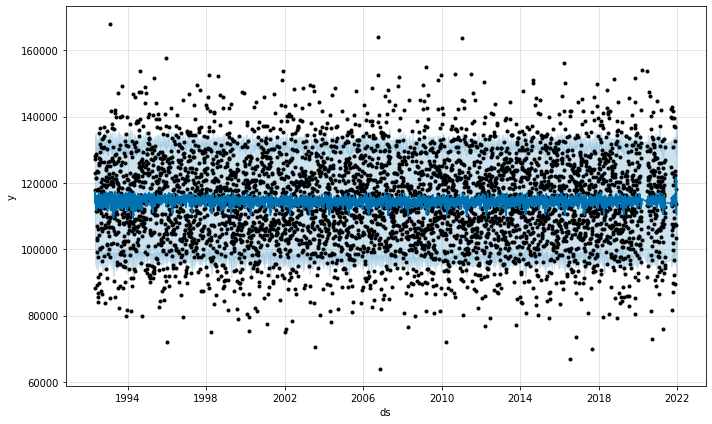

In [15]:
fig1 = m.plot(forecast)

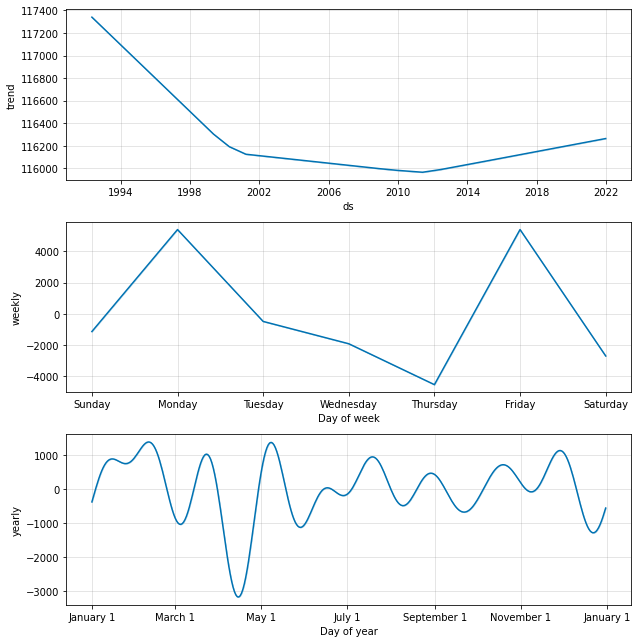

In [16]:
fig2 = m.plot_components(forecast)